In [10]:
import os
import pickle
import numpy as np
import pandas as pd

In [11]:
subj_name = '410'
minutes = 5
personal_ID = 1036

In [12]:
BASE_PATH = (
    f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
    f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/{subj_name}/Data/"
)

# αρχεία:
# test_results_thrX.pkl
# marta_test_results_thrX.pkl


In [13]:
def load_results(prefix):
    """
    prefix = 'test_results' ή 'marta_test_results'
    """
    results = {}

    for fname in os.listdir(BASE_PATH):
        if fname.startswith(prefix) and fname.endswith(".pkl"):
            thr = fname.replace(prefix + "_thr", "").replace(".pkl", "")
            thr = float(thr.replace("_", "."))

            with open(os.path.join(BASE_PATH, fname), "rb") as f:
                results[thr] = pickle.load(f)

    return results


test_results = load_results("test_results")
marta_results = load_results("marta_test_results")

print("Loaded thresholds (TEST): ", sorted(test_results.keys()))
print("Loaded thresholds (MARTA):", sorted(marta_results.keys()))


Loaded thresholds (TEST):  [9.5]
Loaded thresholds (MARTA): [9.5]


In [14]:
rows = []

common_thresholds = sorted(set(test_results) & set(marta_results))

for thr in common_thresholds:

    tr = test_results[thr]
    mr = marta_results[thr]

    rows.append({
        "threshold": thr,

        # ---- TEST ----
        "test_mean_acc": tr["mean_acc"],
        "test_mean_acc_stress": tr["mean_acc_stress"],
        "test_mean_sil": tr["mean_sil"],

        # ---- MARTA ----
        "marta_mean_acc": mr["mean_acc"],
        "marta_mean_acc_stress": mr["mean_acc_stress"],
        "marta_mean_sil": mr["mean_sil"],

        # ---- DIFFERENCES ----
        "Δ_acc": mr["mean_acc"] - tr["mean_acc"],
        "Δ_acc_stress": mr["mean_acc_stress"] - tr["mean_acc_stress"],
        "Δ_sil": mr["mean_sil"] - tr["mean_sil"],
    })

summary_df = pd.DataFrame(rows).sort_values("threshold").reset_index(drop=True)

print("\n================ THRESHOLD COMPARISON =================\n")
display(summary_df)



================ THRESHOLD COMPARISON =================



,threshold,test_mean_acc,test_mean_acc_stress,test_mean_sil,marta_mean_acc,marta_mean_acc_stress,marta_mean_sil,Δ_acc,Δ_acc_stress,Δ_sil
0,9.5,0.569724,0.413839,0.605317,0.495604,0.428227,0.406563,-0.07412,0.014388,-0.198754


In [15]:
long_rows = []

for thr in common_thresholds:

    for fr in test_results[thr]["fold_results"]:
        long_rows.append({
            "threshold": thr,
            "method": "TEST",
            "fold": fr["fold"],
            "acc": fr["acc"],
            "acc_stress": fr["acc_stress"],
            "sil": fr["sil"]
        })

    for fr in marta_results[thr]["fold_results"]:
        long_rows.append({
            "threshold": thr,
            "method": "MARTA",
            "fold": fr["fold"],
            "acc": fr["acc"],
            "acc_stress": fr["acc_stress"],
            "sil": fr["sil"]
        })

long_df = pd.DataFrame(long_rows)

print("\n================ FOLD-LEVEL DATA =================\n")
display(long_df.head())



================ FOLD-LEVEL DATA =================



,threshold,method,fold,acc,acc_stress,sil
0,9.5,TEST,0,0.150100,1.0,NaN
1,9.5,TEST,1,0.149816,1.0,NaN
2,9.5,TEST,2,0.850067,0.0,NaN
3,9.5,TEST,3,0.149749,1.0,NaN
4,9.5,TEST,4,0.849799,0.0,NaN


In [4]:
import pickle
import pandas as pd
from datetime import timedelta

personal_ID = 1036
subj_name = '339'

FILE = (
    f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
    f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/{subj_name}/Data/"
    f"marta_test_results_thr10_5.pkl"   # ← change threshold as needed
)

with open(FILE, "rb") as f:
    data = pickle.load(f)


In [5]:
fold0 = data["fold_results"][0]

time_sec = fold0["time_sec"]          # seconds since t0
ema_idx  = fold0["ema_idx"]
t0_dt    = fold0["t0_datetime"]        # pandas Timestamp


In [6]:
print(fold0.keys())

dict_keys(['fold', 'acc', 'acc_stress', 'sil', 'time_sec', 'ema_idx', 't0_bvp', 't0_datetime', 'n_train', 'n_test', 'n_ema_total', 'n_ema_stress', 'n_ema_calm', 'labels_true_ema', 'labels_pred_ema', 'prob_stress_ema', 'U_test', 'centroids', 'ae_state_dict'])


In [20]:
timestamps = [
    t0_dt + timedelta(seconds=int(s))
    for s in time_sec
]


In [21]:
print("ema_idx:", len(ema_idx))
print("time_sec:", len(time_sec))
print("prob_stress:", len(fold0["prob_stress_ema"]))
print("label_true:", len(fold0["labels_true_ema"]))
print("label_pred:", len(fold0["labels_pred_ema"]))


ema_idx: 5976
time_sec: 5976
prob_stress: 5976
label_true: 5976
label_pred: 5976


In [22]:
# --------------------------------------------------
# ALIGN TO EMA TIMELINE (SAFE & CORRECT)
# --------------------------------------------------

L = len(ema_idx)   # = 5672

ema_idx  = ema_idx[:L]
time_sec = time_sec[:L]

prob_s = fold0["prob_stress_ema"][:L]
y_true = fold0["labels_true_ema"][:L]
y_pred = fold0["labels_pred_ema"][:L]


In [23]:
from datetime import timedelta

t0_dt = fold0["t0_datetime"]   # ή bvp_valid["DateTime"].min()

timestamps = [
    t0_dt + timedelta(seconds=int(s))
    for s in time_sec
]


In [24]:
# allignment with EMA timeline MATTEO FOR ADELFOS 
L = min(
    len(ema_idx),
    len(time_sec),
    len(fold0["prob_stress_ema"]),
    len(fold0["labels_true_ema"]),
    len(fold0["labels_pred_ema"]),
)

ema_idx  = ema_idx[:L]
time_sec = time_sec[:L]

prob_s = fold0["prob_stress_ema"][:L]
y_true = fold0["labels_true_ema"][:L]
y_pred = fold0["labels_pred_ema"][:L]

t0_dt = fold0["t0_datetime"]

timestamps = [
    t0_dt + timedelta(seconds=int(s))
    for s in time_sec
]

timeline_df = pd.DataFrame({
    "ema_idx": ema_idx,
    "time_sec": time_sec,
    "datetime": timestamps,
    "prob_stress": prob_s,
    "label_true": y_true,
    "label_pred": y_pred,
})



In [25]:
print("LENGTH CHECK")
print("ema_idx        :", len(ema_idx))
print("time_sec       :", len(time_sec))
print("prob_stress    :", len(prob_s))
print("label_true     :", len(y_true))
print("label_pred     :", len(y_pred))
print("timestamps     :", len(timestamps))


LENGTH CHECK
ema_idx        : 5976
time_sec       : 5976
prob_stress    : 5976
label_true     : 5976
label_pred     : 5976
timestamps     : 5976


In [26]:
print("\nFIRST 5 ROWS CHECK")
for i in range(5):
    print(
        f"EMA {ema_idx[i]:4d} | "
        f"sec {time_sec[i]:6d} | "
        f"time {timestamps[i]} | "
        f"P(stress) {prob_s[i]:.3f} | "
        f"true {y_true[i]} | pred {y_pred[i]}"
    )



FIRST 5 ROWS CHECK
EMA 56004 | sec  56004 | time 2024-05-15 09:39:48 | P(stress) 0.320 | true 2 | pred 1
EMA 56005 | sec  56005 | time 2024-05-15 09:39:49 | P(stress) 0.311 | true 2 | pred 1
EMA 56006 | sec  56006 | time 2024-05-15 09:39:50 | P(stress) 0.307 | true 2 | pred 1
EMA 56007 | sec  56007 | time 2024-05-15 09:39:51 | P(stress) 0.313 | true 2 | pred 1
EMA 56008 | sec  56008 | time 2024-05-15 09:39:52 | P(stress) 0.310 | true 2 | pred 1


# Matteo

In [27]:
# -----------------------------------------
# 1. COUNTS: TRUE vs PRED (absolute)
# -----------------------------------------
counts_df = pd.DataFrame({
    "true": timeline_df["label_true"].value_counts(),
    "pred": timeline_df["label_pred"].value_counts()
}).fillna(0).astype(int).sort_index()

print("=== COUNTS (absolute) ===")
display(counts_df)


# -----------------------------------------
# 2. COUNTS: TRUE vs PRED (percentages)
# -----------------------------------------
counts_pct_df = pd.DataFrame({
    "true_%": timeline_df["label_true"].value_counts(normalize=True),
    "pred_%": timeline_df["label_pred"].value_counts(normalize=True)
}).sort_index()

print("=== COUNTS (percentages) ===")
display(counts_pct_df)


# -----------------------------------------
# 3. CONFUSION MATRIX (1 = no stress, 2 = stress)
# -----------------------------------------
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(
    timeline_df["label_true"],
    timeline_df["label_pred"],
    labels=[1, 2]
)

cm_df = pd.DataFrame(
    cm,
    index=["true_no_stress (1)", "true_stress (2)"],
    columns=["pred_no_stress (1)", "pred_stress (2)"]
)

print("=== CONFUSION MATRIX ===")
display(cm_df)


# -----------------------------------------
# 4. STRESS RECALL (most important metric)
# -----------------------------------------
if cm[1].sum() > 0:
    stress_recall = cm[1, 1] / cm[1].sum()
else:
    stress_recall = None

print("Stress recall (true stress predicted as stress):", stress_recall)


# -----------------------------------------
# 5. QUICK SANITY CHECK (time ordered)
# -----------------------------------------
print("=== FIRST 20 TIMEPOINTS ===")
display(
    timeline_df
    .sort_values("datetime")[["datetime", "label_true", "label_pred", "prob_stress"]]
    .head(20)
)

=== COUNTS (absolute) ===


,true,pred
1,897,2258
2,5079,3718


=== COUNTS (percentages) ===


,true_%,pred_%
1,0.1501,0.377845
2,0.8499,0.622155


=== CONFUSION MATRIX ===


,pred_no_stress (1),pred_stress (2)
true_no_stress (1),151,746
true_stress (2),2107,2972


Stress recall (true stress predicted as stress): 0.5851545579838551
=== FIRST 20 TIMEPOINTS ===


,datetime,label_true,label_pred,prob_stress
0,2024-05-15 09:39:48,2,1,0.320150
1,2024-05-15 09:39:49,2,1,0.311276
2,2024-05-15 09:39:50,2,1,0.306648
3,2024-05-15 09:39:51,2,1,0.312688
4,2024-05-15 09:39:52,2,1,0.310347
5,2024-05-15 09:39:53,2,1,0.319298
6,2024-05-15 09:39:54,2,1,0.309963
7,2024-05-15 09:39:55,2,1,0.321216
8,2024-05-15 09:39:56,2,1,0.317022
9,2024-05-15 09:39:57,2,1,0.319717


# for adelfos 

In [28]:
# fuction to read the file the right way 
def parse_threshold(fname, prefix):
    thr = fname.replace(prefix + "_thr", "").replace(".pkl", "")
    return float(thr.replace("_", "."))

def load_results(prefix, base_path):
    results = {}

    for fname in os.listdir(base_path):
        if fname.startswith(prefix + "_thr") and fname.endswith(".pkl"):
            thr = parse_threshold(fname, prefix)

            with open(os.path.join(base_path, fname), "rb") as f:
                results[thr] = pickle.load(f)

    return results


In [29]:
personal_ID = 1036 # your personal ID

all_rows = []

subjects = ['487', '486', '483', '482']  # put subjects to analyze

for subj_name in subjects:

    BASE_PATH = (
        f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
        f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/{subj_name}/Data/"
    )

    test_results  = load_results("test_results", BASE_PATH)
    marta_results = load_results("marta_test_results", BASE_PATH)

    # thresholds that exist for BOTH models for THIS person
    common_thresholds = sorted(set(test_results) & set(marta_results))

    for thr in common_thresholds:

        tr = test_results[thr]
        mr = marta_results[thr]

        all_rows.append({
            "subject": subj_name,
            "threshold": thr,
            "method": "TEST",
            "acc": tr["mean_acc"],
            "acc_stress": tr["mean_acc_stress"],
            "sil": tr["mean_sil"],
        })

        all_rows.append({
            "subject": subj_name,
            "threshold": thr,
            "method": "MARTA",
            "acc": mr["mean_acc"],
            "acc_stress": mr["mean_acc_stress"],
            "sil": mr["mean_sil"],
        })

all_df = pd.DataFrame(all_rows)
display(all_df)


,subject,threshold,method,acc,acc_stress,sil
0,487,6.5,TEST,0.124939,1.000000,0.953088
1,487,6.5,MARTA,0.124939,1.000000,0.957485
2,487,8.5,TEST,0.749983,0.142611,0.952377
3,487,8.5,MARTA,0.749983,0.142611,0.954545
4,487,10.5,TEST,0.292232,0.056181,0.945249
5,487,10.5,MARTA,0.291687,0.055455,0.960346
6,486,5.5,TEST,0.333371,1.000000,0.984328
7,486,5.5,MARTA,0.333371,1.000000,0.921521
8,486,6.5,TEST,0.466755,1.000000,0.965326
9,486,6.5,MARTA,0.466755,1.000000,0.926711


In [30]:
# aggregation across subjects
summary = (
    all_df
    .groupby(["threshold", "method"])
    .agg(
        acc_mean=("acc", "mean"),
        acc_std=("acc", "std"),
        acc_stress_mean=("acc_stress", "mean"),
        acc_stress_std=("acc_stress", "std"),
        sil_mean=("sil", "mean"),
        sil_std=("sil", "std"),
        n_subjects=("subject", "nunique"),
    )
    .reset_index()
)

display(summary)


,threshold,method,acc_mean,acc_std,acc_stress_mean,acc_stress_std,sil_mean,sil_std,n_subjects
0,5.5,MARTA,0.333371,NaN,1.000000,NaN,0.921521,NaN,1
1,5.5,TEST,0.333371,NaN,1.000000,NaN,0.984328,NaN,1
2,6.5,MARTA,0.391686,0.238255,1.000000,0.000000,0.938172,0.016823,3
3,6.5,TEST,0.391686,0.238255,1.000000,0.000000,0.962868,0.008812,3
4,7.0,MARTA,0.826023,NaN,0.499832,NaN,0.956892,NaN,1
5,7.0,TEST,0.826023,NaN,0.499832,NaN,0.966440,NaN,1
6,7.5,MARTA,0.666676,NaN,1.000000,NaN,0.919053,NaN,1
7,7.5,TEST,0.666676,NaN,1.000000,NaN,0.947056,NaN,1
8,8.5,MARTA,0.691082,0.211301,0.595179,0.430684,0.944594,0.015177,3
9,8.5,TEST,0.691082,0.211301,0.595179,0.430684,0.956794,0.005749,3


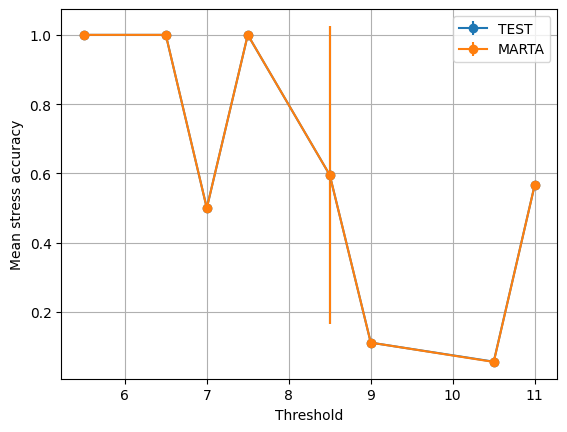

In [31]:
import matplotlib.pyplot as plt

for method in ["TEST", "MARTA"]:
    tmp = summary[summary.method == method]

    plt.errorbar(
        tmp.threshold,
        tmp.acc_stress_mean,
        yerr=tmp.acc_stress_std,
        marker="o",
        label=method
    )

plt.xlabel("Threshold")
plt.ylabel("Mean stress accuracy")
plt.legend()
plt.grid(True)
plt.show()


----------------------------

In [6]:
import pickle
import os
import numpy as np

In [8]:
threshold = 7.5
subj_name = '103'
personal_ID = 1036

BASE_PATH = (
    f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
    f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/{subj_name}/Data/"
)

FILE = os.path.join(
    BASE_PATH,
    f"marta_test_results_thr{str(threshold).replace('.', '_')}.pkl"
    # f"test_results_thr{str(threshold).replace('.', '_')}.pkl"
)

with open(FILE, "rb") as f:
    data = pickle.load(f)

type(data)

dict

In [9]:
data.keys()

dict_keys(['threshold', 'hyperparameters', 'mean_acc', 'mean_acc_stress', 'mean_acc_train', 'mean_acc_stress_train', 'mean_sil', 'mean_f1_stress', 'mean_f1_calm', 'fold_results'])

In [10]:
data['hyperparameters']

{'seq_len': 128,
 'epochs_pre': 1,
 'epochs_train': 30,
 'batch_size': 512,
 'embedding': 30,
 'lr_pretrain': 1e-06,
 'lr_train': 5e-05,
 'sigma': 2,
 'gamma': 0.1}

In [4]:
len(data["fold_results"])
data["fold_results"][0].keys()

dict_keys(['fold', 'acc', 'acc_stress', 'sil', 'time_sec', 'ema_idx', 't0_bvp', 't0_datetime', 'n_train', 'n_test', 'n_ema_total', 'n_ema_stress', 'n_ema_calm', 'labels_true_ema', 'labels_pred_ema', 'prob_stress_ema', 'U_test', 'centroids', 'ae_state_dict'])

In [5]:
fold_results = data["fold_results"]
print(np.unique(fold_results[0]["labels_pred_ema"]))
print(fold_results[0]["U_test"].shape)


[1 2]
(82009, 2)


In [8]:
import numpy as np

fr = data["fold_results"][0]

print("unique TRUE EMA:", np.unique(fr["labels_true_ema"], return_counts=True))
print("unique PRED EMA:", np.unique(fr["labels_pred_ema"], return_counts=True))

# sanity: che range hanno le prob
ps = np.array(fr["prob_stress_ema"])
print("prob_stress_ema min/max:", ps.min(), ps.max())


unique TRUE EMA: (array([1, 2]), array([8362, 4479]))
unique PRED EMA: (array([1, 2]), array([ 1791, 11050]))
prob_stress_ema min/max: 3.4105054e-13 1.0


In [9]:
true = np.array(fr["labels_true_ema"])
ps   = np.array(fr["prob_stress_ema"])

for lab in np.unique(true):
    m = ps[true == lab].mean()
    print("mean prob_stress_ema when true==", lab, ":", m)


mean prob_stress_ema when true== 1 : 0.8570916
mean prob_stress_ema when true== 2 : 0.8669346


In [8]:
w = data["fold_results"][0]["ae_state_dict"]

print(type(w))
print(len(w))

print(list(w.keys())[:10])

for k, v in w.items():
    print(k, v.shape)
    break

w0 = data["fold_results"][0]["ae_state_dict"]
w1 = data["fold_results"][1]["ae_state_dict"]


<class 'collections.OrderedDict'>
34
['encoder.rnn1.weight_ih_l0', 'encoder.rnn1.weight_hh_l0', 'encoder.rnn1.bias_ih_l0', 'encoder.rnn1.bias_hh_l0', 'encoder.rnn2.weight_ih_l0', 'encoder.rnn2.weight_hh_l0', 'encoder.rnn2.bias_ih_l0', 'encoder.rnn2.bias_hh_l0', 'encoder.norm1.weight', 'encoder.norm1.bias']
encoder.rnn1.weight_ih_l0 torch.Size([384, 3])


In [9]:
import os

personal_ID = 1036

BASE_PATH = f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/"

missing_people = {}

for name in os.listdir(BASE_PATH):
    person_path = os.path.join(BASE_PATH, name)
    if not os.path.isdir(person_path):
        continue
    if not name.isdigit():
        continue

    files = os.listdir(os.path.join(person_path, "Data"))

    has_test = any(f.startswith("test_results_") for f in files)
    has_marta = any(f.startswith("marta_test_results_") for f in files)

    if not (has_test and has_marta):
        reason = []
        if not has_test:
            reason.append("missing test_results")
        if not has_marta:
            reason.append("missing marta_test_results")
        missing_people[name] = reason


for k in sorted(missing_people):
    print(k, "->", ", ".join(missing_people[k]))



105 -> missing test_results, missing marta_test_results
114 -> missing marta_test_results
117 -> missing test_results, missing marta_test_results
123 -> missing test_results, missing marta_test_results
136 -> missing test_results, missing marta_test_results
139 -> missing test_results, missing marta_test_results
151 -> missing test_results, missing marta_test_results
154 -> missing test_results, missing marta_test_results
159 -> missing test_results, missing marta_test_results
161 -> missing test_results, missing marta_test_results
164 -> missing test_results, missing marta_test_results
165 -> missing test_results, missing marta_test_results
172 -> missing test_results, missing marta_test_results
176 -> missing test_results, missing marta_test_results
188 -> missing test_results, missing marta_test_results
217 -> missing test_results, missing marta_test_results
238 -> missing test_results, missing marta_test_results
255 -> missing test_results, missing marta_test_results
271 -> missing

In [13]:
print(list(missing_people.keys()))

['105', '473', '489', '136', '389', '139', '303', '305', '271', '114', '384', '238', '159', '172', '117', '123', '457', '164', '313', '176', '151', '161', '188', '165', '217', '255', '416', '154']


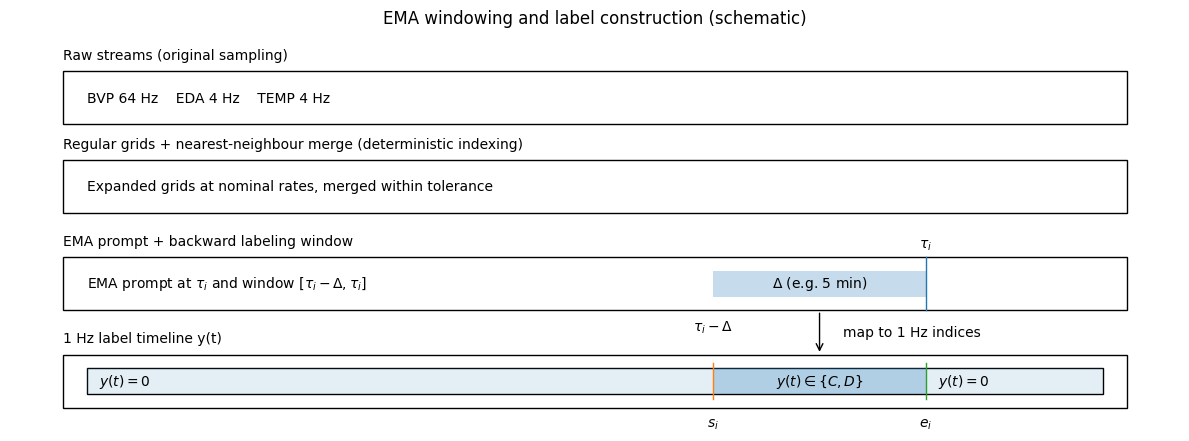

In [1]:
# =========================
# FIG 1) PIPELINE SCHEMATIC
# =========================
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

def plot_pipeline_schematic(delta_minutes=5, outpath=None, show=True):
    """
    Draws a clean schematic of:
    raw streams -> regular grids -> EMA prompt -> backward window -> 1Hz indices -> label timeline
    No data required.
    """
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_axis_off()

    # Lanes
    y_raw, y_grid, y_ema, y_label = 0.78, 0.58, 0.36, 0.14
    lane_h = 0.12

    # Schematic axis limits
    x0, x1 = 0.05, 0.95

    # EMA schematic positions (in [0,1] axis coords)
    x_tau = 0.78
    delta = 0.18
    x_start = x_tau - delta

    # Label bar geometry
    bar_left = x0 + 0.02
    bar_right = x1 - 0.02
    bar_w = bar_right - bar_left

    # Clamp window start/end to bar range to avoid negative widths
    x_start_c = max(bar_left, min(x_start, bar_right))
    x_tau_c   = max(bar_left, min(x_tau,   bar_right))
    # Ensure start <= end (in case someone sets delta negative or weird)
    if x_start_c > x_tau_c:
        x_start_c, x_tau_c = x_tau_c, x_start_c

    # Helpers
    def lane_box(y, title):
        ax.add_patch(Rectangle((x0, y - lane_h/2), x1 - x0, lane_h, fill=False, linewidth=1))
        ax.text(x0, y + lane_h/2 + 0.02, title, va="bottom", ha="left")

    lane_box(y_raw,  "Raw streams (original sampling)")
    lane_box(y_grid, "Regular grids + nearest-neighbour merge (deterministic indexing)")
    lane_box(y_ema,  "EMA prompt + backward labeling window")
    lane_box(y_label,"1 Hz label timeline y(t)")

    # Lane content text
    ax.text(x0 + 0.02, y_raw,  "BVP 64 Hz    EDA 4 Hz    TEMP 4 Hz", va="center", ha="left")
    ax.text(x0 + 0.02, y_grid, "Expanded grids at nominal rates, merged within tolerance", va="center", ha="left")
    ax.text(x0 + 0.02, y_ema,  r"EMA prompt at $\tau_i$ and window $[\tau_i-\Delta,\tau_i]$", va="center", ha="left")

    # EMA lane markers (use unclamped positions for visual, but keep inside [x0,x1])
    x_tau_vis = max(x0, min(x_tau, x1))
    x_start_vis = max(x0, min(x_start, x1))

    ax.plot([x_tau_vis, x_tau_vis], [y_ema - lane_h/2, y_ema + lane_h/2], linewidth=1)
    ax.text(x_tau_vis, y_ema + lane_h/2 + 0.01, r"$\tau_i$", ha="center", va="bottom")

    # EMA window rectangle (clipped inside the lane)
    win_left = min(x_start_vis, x_tau_vis)
    win_right = max(x_start_vis, x_tau_vis)
    win_w = max(0.0, win_right - win_left)

    ax.add_patch(Rectangle((win_left, y_ema - lane_h/4), win_w, lane_h/2, fill=True, alpha=0.25))
    ax.text(win_left + win_w/2, y_ema, rf"$\Delta$ (e.g. {delta_minutes} min)", ha="center", va="center")
    ax.text(x_start_vis, y_ema - lane_h/2 - 0.02, r"$\tau_i-\Delta$", ha="center", va="top")

    # Arrow to label timeline
    arrow_x = win_left + win_w/2 if win_w > 0 else x_tau_vis
    ax.add_patch(FancyArrowPatch((arrow_x, y_ema - lane_h/2),
                                 (arrow_x, y_label + lane_h/2),
                                 arrowstyle="->", mutation_scale=12, linewidth=1))
    ax.text(arrow_x + 0.02, (y_ema + y_label)/2, "map to 1 Hz indices", va="center", ha="left")

    # Label timeline bar outline
    ax.add_patch(Rectangle((bar_left, y_label - lane_h/4), bar_w, lane_h/2, fill=False, linewidth=1))

    # Segments (all widths forced non-negative)
    left_w = max(0.0, x_start_c - bar_left)
    mid_w  = max(0.0, x_tau_c - x_start_c)
    right_w = max(0.0, bar_right - x_tau_c)

    ax.add_patch(Rectangle((bar_left, y_label - lane_h/4), left_w, lane_h/2, fill=True, alpha=0.12))
    ax.add_patch(Rectangle((x_start_c, y_label - lane_h/4), mid_w, lane_h/2, fill=True, alpha=0.35))
    ax.add_patch(Rectangle((x_tau_c, y_label - lane_h/4), right_w, lane_h/2, fill=True, alpha=0.12))

    ax.text(bar_left + 0.01, y_label, r"$y(t)=0$", va="center", ha="left")
    ax.text(x_start_c + mid_w/2 if mid_w > 0 else (bar_left + bar_right)/2,
            y_label, r"$y(t)\in\{C,D\}$", va="center", ha="center")
    ax.text(x_tau_c + 0.01, y_label, r"$y(t)=0$", va="center", ha="left")

    # s_i and e_i markers on the label bar (use clamped)
    ax.plot([x_start_c, x_start_c], [y_label - lane_h/3, y_label + lane_h/3], linewidth=1)
    ax.plot([x_tau_c, x_tau_c],     [y_label - lane_h/3, y_label + lane_h/3], linewidth=1)
    ax.text(x_start_c, y_label - lane_h/2 - 0.02, r"$s_i$", ha="center", va="top")
    ax.text(x_tau_c,   y_label - lane_h/2 - 0.02, r"$e_i$", ha="center", va="top")

    # Title
    ax.text(0.5, 0.98, "EMA windowing and label construction (schematic)",
            ha="center", va="top", fontsize=12)

    plt.tight_layout()

    if outpath:
        fig.savefig(outpath, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)

# Example:
plot_pipeline_schematic(delta_minutes=5, outpath="fig_ema_schematic.pdf")


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# SETTINGS
# -----------------------------
personal_ID = 1036
subj_name = "339"

# choose the Marta threshold file you want to visualize
threshold = 10.5

DELTA_MIN = 5          # EMA window length (minutes)
FS = 4                 # after preprocessing() in your pipeline
SEQ_LEN = 128          # used later only if you want to compare with window size

# -----------------------------
# IMPORT Marta preprocessing
# -----------------------------
import sys
sys.path.append(
    f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
    f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/Code/Marta"
)
from deepemotions.preprocess import preprocessing

# -----------------------------
# PATHS
# -----------------------------
BASE_PATH = (
    f"/run/user/{personal_ID}/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/"
    f"Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed/{subj_name}/Data/"
)

EMPATICA_FILE = os.path.join(BASE_PATH, "ALL_DAYS_PROCESSED_BIG.pickle")
MODEL_FILE = os.path.join(
    BASE_PATH,
    f"marta_test_results_thr{str(threshold).replace('.', '_')}.pkl"
)

# -----------------------------
# LOAD EMPATICA DAYS + CONCAT
# -----------------------------
with open(EMPATICA_FILE, "rb") as f:
    alldata = pickle.load(f)

EDA_subj = pd.concat([alldata[day]["eda_subj"] for day in alldata.keys()]).sort_values("Timestamp")
BVP_subj = pd.concat([alldata[day]["bvp_subj"] for day in alldata.keys()]).sort_values("Timestamp")
TEMP_subj = pd.concat([alldata[day]["temp_subj"] for day in alldata.keys()]).sort_values("Timestamp")

# Empatica start time (same idea you used)
t0_empatica = pd.to_datetime(EDA_subj["Timestamp"].min(), unit="s")

eda  = EDA_subj["Values"].values
bvp  = BVP_subj["Values"].values
temp = TEMP_subj["Values"].values

# -----------------------------
# PREPROCESS (your same routine)
# signal_full: shape (T, 3) at FS=4Hz
# -----------------------------
signal_full, time_full = preprocessing(
    eda,
    bvp,
    temp,
    cardio_sampling_rate=64,
    bvp=True,
    init_time=0
)

T = signal_full.shape[0]
time_full_datetime = t0_empatica + pd.to_timedelta(np.arange(T) / FS, unit="s")

df_signals = pd.DataFrame(
    signal_full,
    columns=["EDA", "BVP", "TEMP"]
)
df_signals["time"] = time_full_datetime

print("signal_full shape:", signal_full.shape)
print("time range:", df_signals["time"].min(), "→", df_signals["time"].max())

# -----------------------------
# LOAD EMA prompt times from Marta pickle
# -----------------------------
with open(MODEL_FILE, "rb") as f:
    model_data = pickle.load(f)

fold0 = model_data["fold_results"][0]

# these keys exist in your example
ema_idx = np.array(fold0["ema_idx"])         # indices in seconds (1Hz reference) in Marta code
t0_dt = fold0["t0_datetime"]                 # usually already a datetime-like

t0_dt = pd.to_datetime(t0_dt)
ema_times = t0_dt + pd.to_timedelta(ema_idx, unit="s")

print("n EMA prompts:", len(ema_times))
print("first / last EMA:", ema_times.min(), "→", ema_times.max())

# keep only EMA prompts that actually fall in the preprocessed signal time span
ema_times = ema_times[(ema_times >= df_signals["time"].min()) & (ema_times <= df_signals["time"].max())]
print("EMA prompts within signal range:", len(ema_times))

# -----------------------------
# PLOT A: Overview with EMA windows shaded
# -----------------------------
delta = pd.Timedelta(minutes=DELTA_MIN)

fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
cols = ["EDA", "BVP", "TEMP"]

for ax, col in zip(axes, cols):
    ax.plot(df_signals["time"], df_signals[col], linewidth=0.6)
    ax.set_ylabel(col)

    # shade EMA windows [tau-Delta, tau] and mark tau
    for tau in ema_times:
        ax.axvspan(tau - delta, tau, alpha=0.15)
        ax.axvline(tau, linewidth=0.8, alpha=0.6)

axes[-1].set_xlabel("Time")
fig.suptitle(f"Subject {subj_name} Empatica signals with EMA windows (Δ={DELTA_MIN} min)")
plt.tight_layout()
plt.show()

# -----------------------------
# PLOT B: Zoom inside ONE EMA window
# -----------------------------
if len(ema_times) == 0:
    raise RuntimeError("No EMA prompts inside the Empatica time range, nothing to plot.")

i_ema = 0  # change this to pick another prompt
tau = ema_times.iloc[i_ema] if isinstance(ema_times, pd.Series) else ema_times[i_ema]

start = tau - delta
end = tau

df_zoom = df_signals[(df_signals["time"] >= start) & (df_signals["time"] <= end)].copy()

fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

for ax, col in zip(axes, cols):
    ax.plot(df_zoom["time"], df_zoom[col], linewidth=1.0)
    ax.axvline(tau, linewidth=1.0, alpha=0.8)
    ax.set_ylabel(col)

axes[-1].set_xlabel("Time")
fig.suptitle(f"Zoom inside EMA window [{start} , {end}] for subject {subj_name}")
plt.tight_layout()
plt.show()


signal_full shape: (58267814, 3)
time range: 2024-04-25 12:21:51 → 2024-10-11 02:44:24.250000
n EMA prompts: 12841
first / last EMA: 2024-04-25 17:38:57 → 2024-05-12 16:38:48
EMA prompts within signal range: 12841


KeyboardInterrupt: 